In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset class for GasHisSDB
class GasHisSDBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['normal', 'abnormal']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.samples = []
        
        # Collect samples
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
                
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                    self.samples.append((
                        os.path.join(class_dir, img_name),
                        self.class_to_idx[class_name]
                    ))
        
        # Print dataset statistics
        normal_count = sum(1 for _, label in self.samples if label == 0)
        abnormal_count = sum(1 for _, label in self.samples if label == 1)
        print(f"Dataset loaded with {len(self.samples)} images:")
        print(f"  - Normal: {normal_count}")
        print(f"  - Abnormal: {abnormal_count}")
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder black image and the label
            image = Image.new('RGB', (120, 120), color='black')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define a custom CNN model
class GastricCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(GastricCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate size after convolutions for 120x120 input
        # After 4 pooling layers of stride 2: 120 -> 60 -> 30 -> 15 -> 7
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.relu5 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 128)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Convolutional layers
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout1(self.relu5(self.fc1(x)))
        x = self.dropout2(self.relu6(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Create a ResNet-based model (transfer learning)
def create_resnet_model(num_classes=2):
    model = models.resnet18(pretrained=True)
    
    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    # Track best model
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    # History for plotting
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Record history for plotting
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Learning rate scheduling
                scheduler.step(epoch_loss)
                
                # Deep copy the model if it's the best
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict().copy()
        
        print()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f'Test Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(cm)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# Function to plot the training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes=['Normal', 'Abnormal']):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Main execution function
def run_training(data_dir, batch_size=32, num_epochs=20, learning_rate=0.001, model_type='resnet'):
    # Configure transforms for data augmentation
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Simpler transform for validation/test
    eval_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset
    full_dataset = GasHisSDBDataset(root_dir=data_dir, transform=None)
    
    # Split dataset
    dataset_size = len(full_dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    # Apply different transforms to each split
    train_dataset = TransformedSubset(train_dataset, train_transform)
    val_dataset = TransformedSubset(val_dataset, eval_transform)
    test_dataset = TransformedSubset(test_dataset, eval_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    print(f"Dataset split: {train_size} training, {val_size} validation, {test_size} test samples")
    
    # Create model
    if model_type == 'custom':
        model = GastricCNN(num_classes=2)
    else:  # 'resnet' or other
        model = create_resnet_model(num_classes=2)
    
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=5, verbose=True
    )
    
    # Train the model
    print(f"Training {model_type} model...")
    model, history = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate the model
    print("\nEvaluating model on test set:")
    metrics = evaluate_model(model, test_loader)
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics['confusion_matrix'])
    
    # Save the model
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), f'models/gastric_cnn_{model_type}.pth')
    print(f"Model saved as models/gastric_cnn_{model_type}.pth")
    
    return model, history, metrics

# Helpers for dataset transforms
class TransformedSubset(Dataset):
    """Apply transform to a subset of a dataset"""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

# You can run this in Jupyter notebook with:
# run_training(data_dir='/gpfs/scratch/hz3106/Gashisdb_processed/120x120', model_type='resnet')

Using device: cuda


Dataset loaded with 146937 images:
  - Normal: 21961
  - Abnormal: 124976
Dataset split: 102855 training, 22040 validation, 22042 test samples
Training resnet model...
Epoch 1/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3656 Acc: 0.8572


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.4075 Acc: 0.8590

Epoch 2/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3538 Acc: 0.8613


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3270 Acc: 0.8735

Epoch 3/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3548 Acc: 0.8601


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3289 Acc: 0.8714

Epoch 4/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3540 Acc: 0.8608


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3257 Acc: 0.8727

Epoch 5/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3560 Acc: 0.8611


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3524 Acc: 0.8585

Epoch 6/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3553 Acc: 0.8593


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3217 Acc: 0.8741

Epoch 7/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3532 Acc: 0.8603


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3257 Acc: 0.8734

Epoch 8/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3523 Acc: 0.8613


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3282 Acc: 0.8740

Epoch 9/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3535 Acc: 0.8609


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3216 Acc: 0.8762

Epoch 10/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3513 Acc: 0.8607


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3235 Acc: 0.8740

Epoch 11/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3526 Acc: 0.8604


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3616 Acc: 0.8656

Epoch 12/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3516 Acc: 0.8609


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3235 Acc: 0.8730

Epoch 13/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3530 Acc: 0.8610


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3448 Acc: 0.8585

Epoch 14/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3538 Acc: 0.8606


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3266 Acc: 0.8716

Epoch 15/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3519 Acc: 0.8618


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3397 Acc: 0.8677

Epoch 16/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3394 Acc: 0.8647


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3148 Acc: 0.8757

Epoch 17/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3378 Acc: 0.8655


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3156 Acc: 0.8739

Epoch 18/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3354 Acc: 0.8659


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3172 Acc: 0.8745

Epoch 19/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3350 Acc: 0.8669


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3185 Acc: 0.8749

Epoch 20/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.3349 Acc: 0.8670


val:   0%|          | 0/689 [00:00<?, ?it/s]

val Loss: 0.3180 Acc: 0.8735



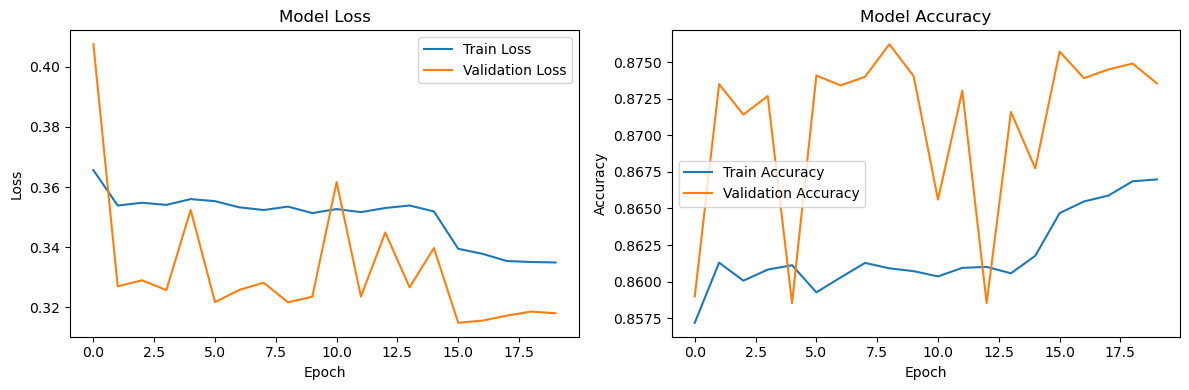


Evaluating model on test set:


Testing:   0%|          | 0/689 [00:00<?, ?it/s]

Test Accuracy: 0.8698
Precision: 0.8519
Recall: 0.8698
F1 Score: 0.8417
Confusion Matrix:
[[  803  2523]
 [  347 18369]]


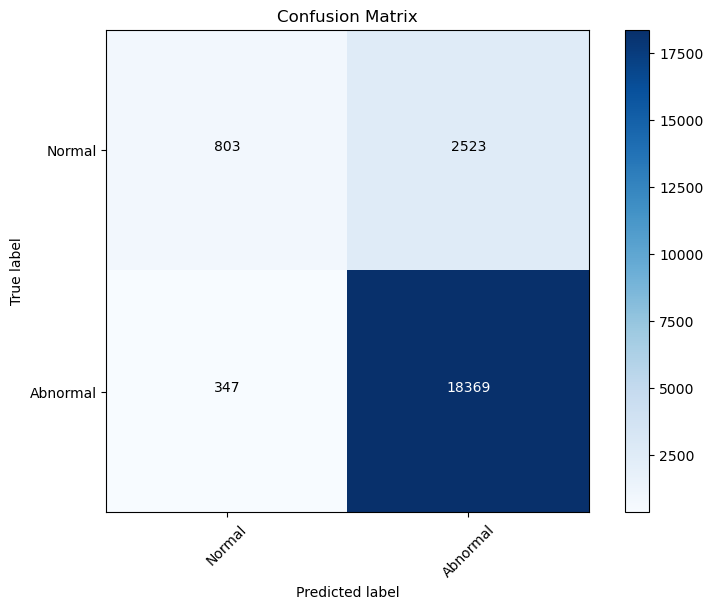

Model saved as models/gastric_cnn_resnet.pth


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [3]:
run_training(data_dir='/gpfs/scratch/hz3106/Gashisdb_processed/120x120', model_type='resnet')